# Использование нейронного алгоритма переноса стиля для стилизации изображений


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from matplotlib import pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

- **Описание набора данных.**

Данные представляют собой два изображения

In [2]:
content_image_path = '../images/content/Tuebingen_Neckarfront.jpg'
style_image_path = '../images/style/vangogh_starry_night.jpg'

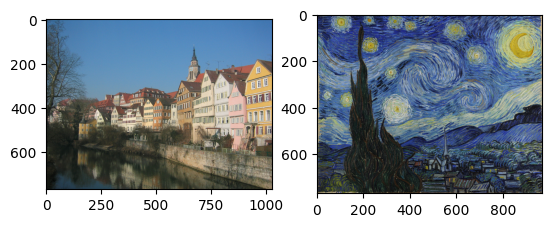

In [3]:
content_image = Image.open(content_image_path)
style_image = Image.open(style_image_path)

plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

- **Предварительная обработка данных.**

Для алгоритма надо лишь изменить размер входного изображения, так чтобы большая сторона была равна 512. Это нужно лишь для работы алгоритма на видеокарте, так как на моих 4гб видеопамяти, больше не влезает.

А также перевести все из [0..255]  в [0..1]

In [5]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu
content_image_size = Image.open(content_image_path).size
scale_factor = imsize / max(content_image_size)
resize = (int(content_image_size[0] * scale_factor), int(content_image_size[1] * scale_factor))
resize = resize[::-1]  #PIL return (width, height). PyTorch needs (height, width)

preprocess_resize_toTensor = transforms.Compose(
    [
        transforms.Resize(resize),  # scale imported image
        transforms.ToTensor(),  # scale value to [0..1]
    ]
)  # transform it into a torch tensor

In [6]:
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = preprocess_resize_toTensor(image).unsqueeze(0)
    return image.to(device, torch.float)


content_img_tensor = image_loader(content_image_path)
style_img_tensor = image_loader(style_image_path)

# assert content_img_tensor.size() == style_img_tensor.size()

In [7]:
def tensor_toImage(tensor: torch.Tensor) -> Image:
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    return image

In [8]:
# tensor_toImage(content_img_tensor).show()
# tensor_toImage(style_img_tensor).show()

- **Постановка задачи и построение модели.**

Создадим дополнительные модули для подсчета функций потерь и внедрим их в модель VGG19

In [9]:
# normalization https://pytorch.org/vision/stable/models/generated/torchvision.models.vgg19.html#torchvision.models.vgg19
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


# нормализация будет представлять из себя отдельный модуль помещенный в самое начало через nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # для правильной работы с каналами представим тензоры выше в формате [C, 1, 1]
        # С в данном случае превратится в 3, как количество каналов в изображении
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std


In [10]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [11]:
def gram_matrix(input):
    a, b, c, d = input.size()
    # a=батч сайз(=1)
    # b=количество карт признаков сверточного слоя
    # (c,d)=размер карты признаков (N=c*d)

    features = input.view(a * b, c * d)  # каждую карту признаков развернем в одномерный массив
    G = torch.mm(features, features.t())  # матрица Грама

    # для уравновешивания вклада с разных слоев, будем нормализовать матрицу
    return G.div(a * b * c * d)

In [12]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


Загружаем сверточную сеть

С помощью *.features* мы загружаем сеть без последних полносвязных слоев

In [13]:
cnn = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Данная функция служит для внедрения модулей подсчет ошибок после выбранных слоев в прямое прохождение модели

In [14]:
content_layers_default = ['relu5_2']
style_layers_default = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']


def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               content_img, style_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # модуль нормализации
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    model = nn.Sequential(normalization)
    content_losses = []
    style_losses = []

    block = 1
    i = 1
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            name = f'conv{block}_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu{block}_{i}'
            layer = nn.ReLU(inplace=False)
            i += 1
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool{block}_{i}'
            block += 1
            i = 1
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn{block}_{i}'
        else:
            raise RuntimeError(f'Неизвестный слой: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss{block}_{i}', content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f'style_loss{block}_{i}', style_loss)
            style_losses.append(style_loss)

    # откидываем все что после последнего нужного слоя
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [15]:
# Данный оптимизатор продемонстрировал самые стабильные результаты без сложного подбора и настройки параметров
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

Основной метод переноса стиля

In [19]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):

    # получаем перестроенную модель и прямые ссылки на модули ошибок
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                     normalization_mean, normalization_std,
                                                                     content_img=content_img,
                                                                     style_img=style_img)

    # Изображение оптимизируем, а модель не трогаем
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            # пропускаем изображение через модель
            model(input_img)
            style_score = 0
            content_score = 0

            # складываем ошибку со всех выбранных слоев
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            # умножаем на весовые коэффициенты
            style_score *= style_weight
            content_score *= content_weight

            # считаем общую функцию потерь и градиенты к ней
            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print(f'Total loss: {loss.item():4f}')
                plt.figure()
                plt.imshow(tensor_toImage(input_img.clamp(0, 1)))
                plt.pause(1)

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

C:\Users\lbi20\AppData\Local\Temp\ipykernel_20388\528548477.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\lbi20\AppData\Local\Temp\ipykernel_20388\528548477.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 1.511439 Content Loss: 1.115339
Total loss: 2.626778


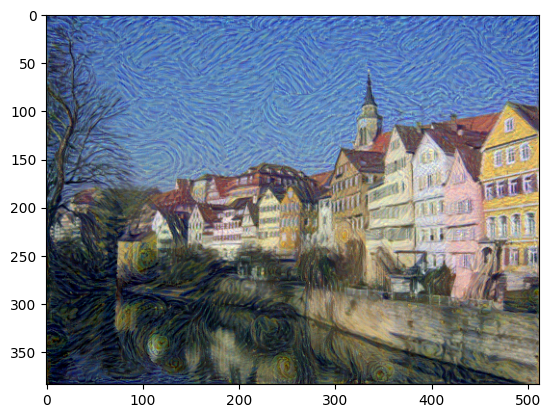

run [100]:
Style Loss : 0.857744 Content Loss: 0.892138
Total loss: 1.749882


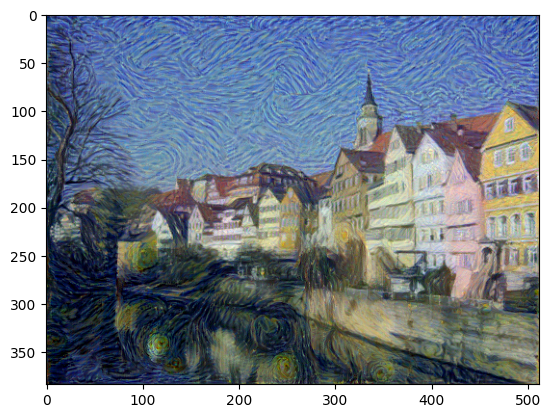

run [150]:
Style Loss : 0.692324 Content Loss: 0.823155
Total loss: 1.515479


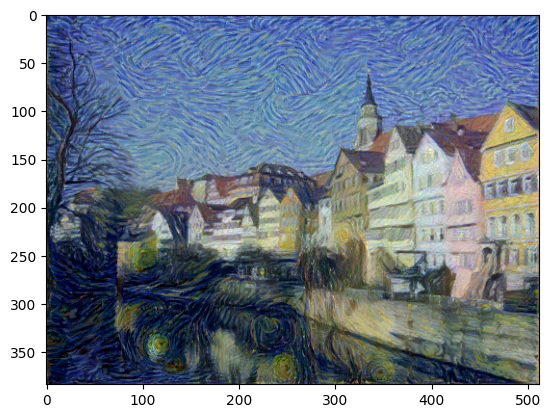

run [200]:
Style Loss : 0.624515 Content Loss: 0.787090
Total loss: 1.411605


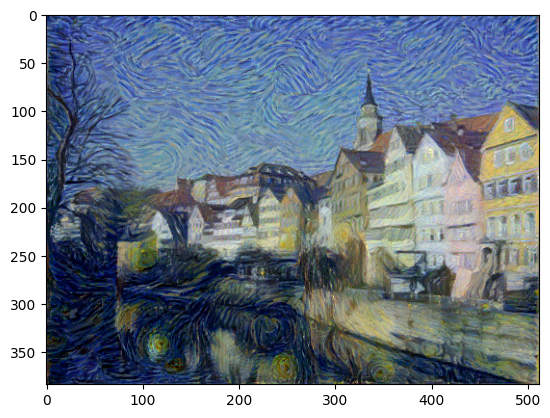

run [250]:
Style Loss : 0.589550 Content Loss: 0.766246
Total loss: 1.355796


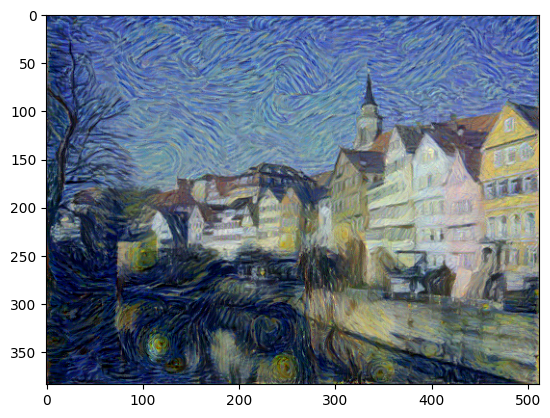

run [300]:
Style Loss : 0.567900 Content Loss: 0.754075
Total loss: 1.321976


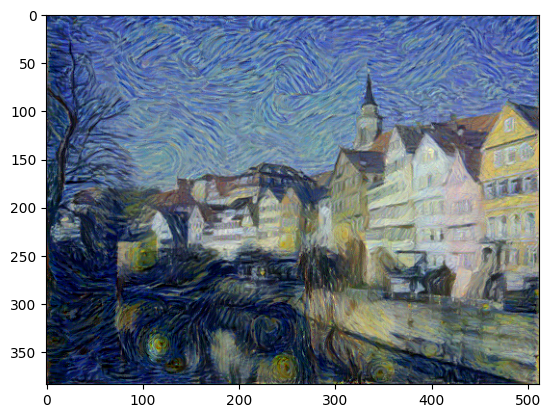

run [350]:
Style Loss : 0.554103 Content Loss: 0.744884
Total loss: 1.298987


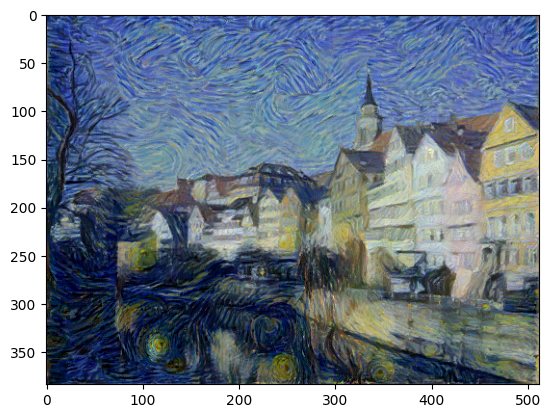

run [400]:
Style Loss : 0.544288 Content Loss: 0.737964
Total loss: 1.282252


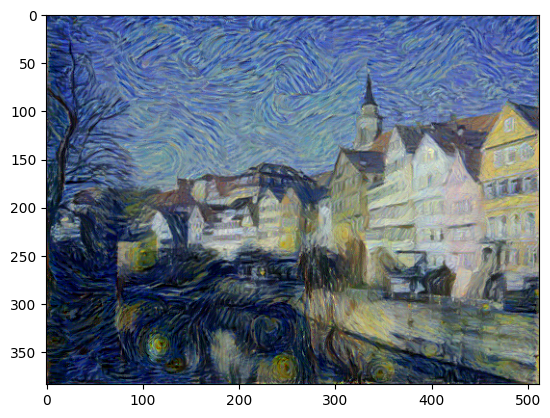

run [450]:
Style Loss : 0.536037 Content Loss: 0.733473
Total loss: 1.269510


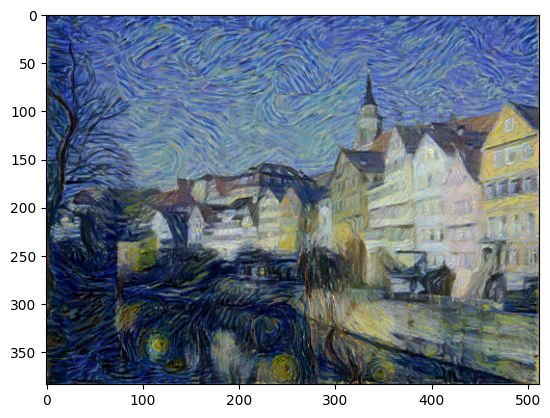

run [500]:
Style Loss : 0.529930 Content Loss: 0.729572
Total loss: 1.259502


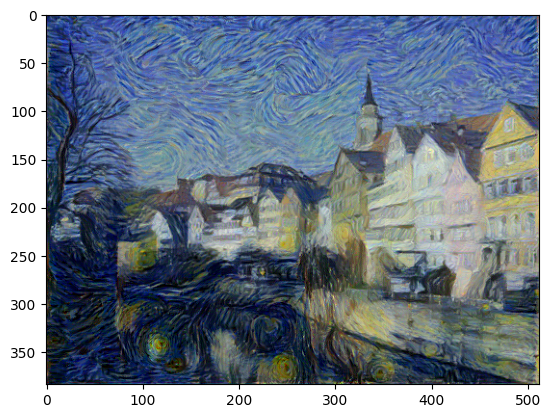

In [20]:
# Для получения различных результатов добавим к исходному изображению немного шума и запустим оптимизацию
input_img = content_img_tensor.clone() + (torch.rand(content_img_tensor.size()).to(device) - 0.5) / 30
result = run_style_transfer(
    cnn, cnn_normalization_mean, cnn_normalization_std,
    content_img=content_img_tensor,
    style_img=style_img_tensor,
    input_img=input_img,
    num_steps=500,
    style_weight=1e6,
    content_weight=1
)

- Оценка модели и результатов.

К сожалению нет каких то известных мне метрик для измерения эстетической составляющей результата

По моему мнению вышло довольно хорошо.

Так же в рамках работы был проведен опрос, где сравнивались сервисы Phosus, AnyTools, Free Style Transfer и разработанный алгоритм, где алгоритм показал себя лучше всех в качестве. Естественно временные затраты не учитывались

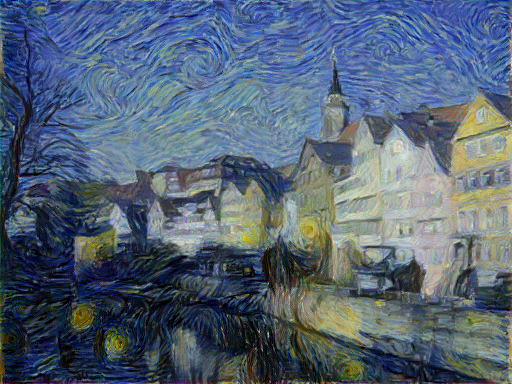

In [18]:
tensor_toImage(result)